In [551]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs, plot_numerical_diffs_single

In [552]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

In [553]:
# non tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]

# tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 96 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 94 registers, 448 bytes cmem[0]

## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [554]:
from src.gpu_info.gpu_info import get_gpu_info

In [555]:
# get_gpu_info(0)

### define inputs

In [556]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 64 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [557]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs[:,:,1,0] = 7.
qs[:,:,1,0] = 1.

vs[:,:,1,16] = 8.
qs[:,:,1,16] = 1.
# random: 
# qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [558]:
# qs[:, :, 16,0] = 1.

In [559]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [560]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [561]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [562]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [563]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [564]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.0008217431604862213
fw n match: False, max diff: 0.04561877250671387
fw m match: False, max diff: 0.030748605728149414
fw D match: False, max diff: 0.01139909029006958
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.01211535930633545
fw n match: False, max diff: 0.1731654405593872
fw m match: False, max diff: 0.14853811264038086
fw D match: False, max diff: 0.07008630037307739


### match directly

In [565]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [566]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

In [567]:
s_pt_half = (qs_half @ ks_half.transpose(-2, -1)).tril()
s_pt_half.shape

torch.Size([1, 1, 64, 64])

In [568]:
def lower_triangular_block_matrix(n, block_size):
    assert n % block_size == 0
    n_blocks = n // block_size
    
    mat = torch.zeros((n, n), device=DEVICE, dtype=DTYPE)
    for i in range(n_blocks):
        mat[i*block_size:(i+1)*block_size, :(i+1)*block_size] = 1.
    return mat

In [569]:
# compute the baseline for qkv tensor core computation
ltr_bmat = lower_triangular_block_matrix(S, 16)
s_block_pt = (qs @ ks.transpose(-2, -1)) * ltr_bmat
qkv_block_pt = s_block_pt @ vs

In [570]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 64
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-1, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 67840
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64
qTLdx=0|kvTLdx=0: wId=0|lId=0,TidxX=0: hWBIdxXY(0,0), hTileSMXY(0,0)=0.532332
qTLdx=0|kvTLdx=0: wId=0|lId=16,TidxX=16: hWBIdxXY(0,0), hTileSMXY(16,0)=0.554035
qTLdx=0|kvTLdx=0: wId=1|lId=0,TidxX=32: hWBIdxXY(0,0), hTileSMXY(0,1)=2.178818
qTLdx=0|kvTLdx=0: wId=1|lId=16,TidxX=48: hWBIdxXY(0,0), hTileSMXY(16,1)=2.267647
qTLdx=0|kvTLdx=0: wId=3|lId=0,TidxX=96: hWBIdxXY(0,0), hTileSMXY(0,3)=0.532332
qTLdx=0|kvTLdx=0: wId=3|lId=16,TidxX=112: hWBIdxXY(0,0), hTileSMXY(16,3)=0.554035
qTLdx=0|kvTLdx=0: wId=2|lId=0,TidxX=64: hWBIdxXY(0,0), hTileSMXY(0,2)=0.532332
qTLdx=0|kvTLdx=0: wId=2|lId=16,TidxX=80: hWBIdxXY(0,0), hTileSMXY(16,2)=0.554035
qTLdx=0|kvTLdx=0: wId=2|lId=0,Tid

In [571]:
s_pt_half[:, :, 16:33, 16:33]

tensor([[[[0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

In [572]:
matD_cu_half[:, :, 16:33, 16:33]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.006

In [573]:
vs_half[:, :, 48:49, :12]

tensor([[[[30.7188, 30.7344, 30.7344, 30.7500, 30.7656, 30.7656, 30.7812, 30.7969, 30.7969, 30.8125, 30.8125, 30.8281]]]], device='cuda:0', dtype=torch.float16)

In [574]:
qkv_block_pt[:, :, :64, :17]

tensor([[[[0.5322, 0.4925, 0.4936, 0.4946, 0.4956, 0.4966, 0.4977, 0.4987, 0.4997, 0.5007, 0.5018, 0.5028, 0.5038, 0.5048, 0.5059, 0.5069, 0.5540],
          [2.1788, 2.0164, 2.0205, 2.0247, 2.0289, 2.0331, 2.0373, 2.0415, 2.0457, 2.0499, 2.0541, 2.0583, 2.0625, 2.0667, 2.0708, 2.0750, 2.2679],
          [0.5322, 0.4925, 0.4936, 0.4946, 0.4956, 0.4966, 0.4977, 0.4987, 0.4997, 0.5007, 0.5018, 0.5028, 0.5038, 0.5048, 0.5059, 0.5069, 0.5540],
          [0.5322, 0.4925, 0.4936, 0.4946, 0.4956, 0.4966, 0.4977, 0.4987, 0.4997, 0.5007, 0.5018, 0.5028, 0.5038, 0.5048, 0.5059, 0.5069, 0.5540],
          [0.5322, 0.4925, 0.4936, 0.4946, 0.4956, 0.4966, 0.4977, 0.4987, 0.4997, 0.5007, 0.5018, 0.5028, 0.5038, 0.5048, 0.5059, 0.5069, 0.5540],
          [0.5322, 0.4925, 0.4936, 0.4946, 0.4956, 0.4966, 0.4977, 0.4987, 0.4997, 0.5007, 0.5018, 0.5028, 0.5038, 0.5048, 0.5059, 0.5069, 0.5540],
          [0.5322, 0.4925, 0.4936, 0.4946, 0.4956, 0.4966, 0.4977, 0.4987, 0.4997, 0.5007, 0.5018, 0.5028, 0.503

In [575]:
t1 = torch.tensor([8.3190], dtype=torch.float32, device=DEVICE)
print(t1)
print(t1.half())

tensor([8.3190], device='cuda:0')
tensor([8.3203], device='cuda:0', dtype=torch.float16)


In [576]:
hs_cu_half[:, :, :64, 32:48]

tensor([[[[0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396],
          [2.1465, 2.1504, 2.1543, 2.1582, 2.1621, 2.1660, 2.1719, 2.1758, 2.1797, 2.1836, 2.1875, 2.1934, 2.1973, 2.2012, 2.2051, 2.2090],
          [0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396],
          [0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396],
          [0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396],
          [0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396],
          [0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396],
          [0.5244, 0

tensor(0.0054, device='cuda:0')

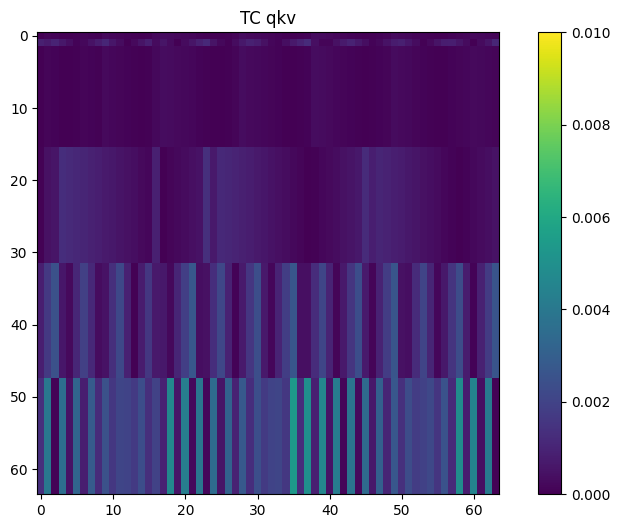

In [577]:
fig = plot_numerical_diffs_single(hs_cu_half, qkv_block_pt, title="TC qkv", vmax=0.01)
(hs_cu_half - qkv_block_pt).abs().max()

In [578]:
s_pt_half[:, :, :16, :16]

tensor([[[[0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0262, 0.0262, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0

In [579]:
matD_cu_half[:, :, :10, 0:17]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.006

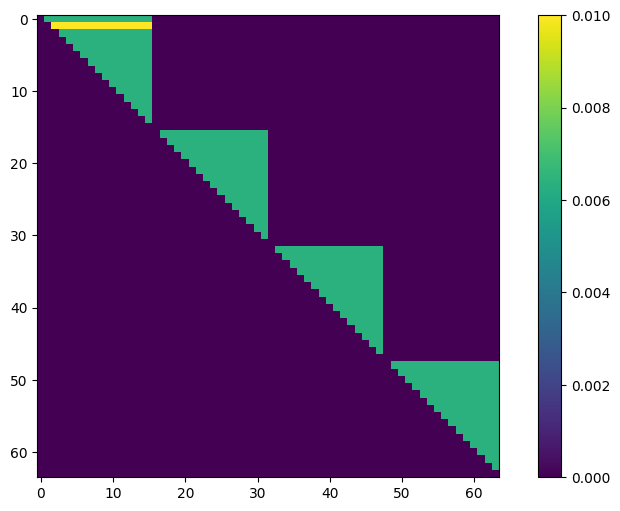

In [580]:
fig = plot_numerical_diffs_single(s_pt_half, matD_cu_half)

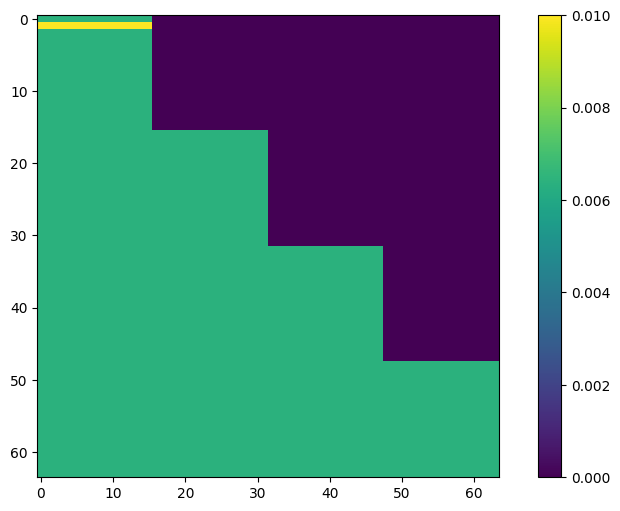

In [581]:
fig = plot_numerical_diffs_single(matD_cu_half)

In [582]:
s_pt_half[:, :, :10, :10]

tensor([[[[0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0262, 0.0262, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064]]]], device='cuda:0', dtype=torch.float16)

In [583]:
(s_pt_half - matD_cu_half)[:, : , :10, :10]

tensor([[[[ 0.0000, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064],
          [ 0.0000,  0.0000, -0.0262, -0.0262, -0.0262, -0.0262, -0.0262, -0.0262, -0.0262, -0.0262],
          [ 0.0000,  0.0000,  0.0000, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0064, -0.0064, -0.0064, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0064, -0.0064, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0064, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0064],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,

In [584]:
(s_pt_half - matD_cu_half).abs().max()

tensor(0.0262, device='cuda:0', dtype=torch.float16)

In [585]:
vs_half[:, :, :3, 32:]

tensor([[[[0.3201, 0.3301, 0.3401, 0.3501, 0.3601, 0.3701, 0.3799, 0.3899, 0.3999, 0.4099, 0.4199, 0.4299, 0.4399, 0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5098, 0.5200, 0.5298, 0.5400,
           0.5498, 0.5601, 0.5698, 0.5801, 0.5898, 0.6001, 0.6099, 0.6201, 0.6299],
          [0.9600, 0.9702, 0.9800, 0.9902, 1.0000, 1.0098, 1.0195, 1.0303, 1.0400, 1.0498, 1.0596, 1.0703, 1.0801, 1.0898, 1.0996, 1.1104, 1.1201, 1.1299, 1.1396, 1.1504, 1.1602, 1.1699, 1.1797,
           1.1904, 1.2002, 1.2100, 1.2197, 1.2305, 1.2402, 1.2500, 1.2598, 1.2695],
          [1.5996, 1.6104, 1.6201, 1.6299, 1.6396, 1.6504, 1.6602, 1.6699, 1.6797, 1.6904, 1.7002, 1.7100, 1.7197, 1.7305, 1.7402, 1.7500, 1.7598, 1.7695, 1.7803, 1.7900, 1.7998, 1.8096, 1.8203,
           1.8301, 1.8398, 1.8496, 1.8604, 1.8701, 1.8799, 1.8896, 1.9004, 1.9102]]]], device='cuda:0', dtype=torch.float16)

In [586]:
matD_cu_half.shape

torch.Size([1, 1, 64, 64])

In [587]:
matD_cu_half[:, :, :10, :10]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064]]]], device='cuda:0', dtype=torch.float16)

In [588]:
hs_cu_half[:, :, :3, 32:]

tensor([[[[0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396, 0.5405, 0.5420, 0.5430, 0.5439, 0.5449, 0.5459, 0.5469,
           0.5479, 0.5488, 0.5498, 0.5508, 0.5518, 0.5532, 0.5542, 0.5552, 0.5562],
          [2.1465, 2.1504, 2.1543, 2.1582, 2.1621, 2.1660, 2.1719, 2.1758, 2.1797, 2.1836, 2.1875, 2.1934, 2.1973, 2.2012, 2.2051, 2.2090, 2.2129, 2.2168, 2.2227, 2.2266, 2.2305, 2.2344, 2.2383,
           2.2422, 2.2461, 2.2520, 2.2559, 2.2598, 2.2637, 2.2676, 2.2715, 2.2773],
          [0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376, 0.5386, 0.5396, 0.5405, 0.5420, 0.5430, 0.5439, 0.5449, 0.5459, 0.5469,
           0.5479, 0.5488, 0.5498, 0.5508, 0.5518, 0.5532, 0.5542, 0.5552, 0.5562]]]], device='cuda:0', dtype=torch.float16)

In [589]:
(vs_half-hs_cu_half)[:, :, :3, 32:]

tensor([[[[-0.2043, -0.1953, -0.1863, -0.1772, -0.1682, -0.1592, -0.1509, -0.1418, -0.1328, -0.1238, -0.1147, -0.1057, -0.0967, -0.0876, -0.0786, -0.0696, -0.0605, -0.0520, -0.0430, -0.0342, -0.0249,
           -0.0161, -0.0068,  0.0020,  0.0112,  0.0200,  0.0293,  0.0381,  0.0469,  0.0557,  0.0649,  0.0737],
          [-1.1865, -1.1797, -1.1738, -1.1680, -1.1621, -1.1562, -1.1523, -1.1455, -1.1396, -1.1338, -1.1279, -1.1230, -1.1172, -1.1113, -1.1055, -1.0986, -1.0928, -1.0869, -1.0830, -1.0762, -1.0703,
           -1.0645, -1.0586, -1.0518, -1.0459, -1.0420, -1.0361, -1.0293, -1.0234, -1.0176, -1.0117, -1.0078],
          [ 1.0752,  1.0850,  1.0938,  1.1025,  1.1113,  1.1211,  1.1289,  1.1387,  1.1465,  1.1562,  1.1660,  1.1738,  1.1836,  1.1934,  1.2012,  1.2109,  1.2188,  1.2275,  1.2373,  1.2461,  1.2549,
            1.2637,  1.2734,  1.2822,  1.2910,  1.2998,  1.3096,  1.3184,  1.3262,  1.3359,  1.3457,  1.3535]]]], device='cuda:0', dtype=torch.float16)

In [590]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 64
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-1, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 67840
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64
qTLdx=0|kvTLdx=0: wId=0|lId=0,TidxX=0: hWBIdxXY(0,0), hTileSMXY(0,0)=0.532923
qTLdx=0|kvTLdx=0: wId=0|lId=16,TidxX=16: hWBIdxXY(0,0), hTileSMXY(16,0)=0.554577
qTLdx=0|kvTLdx=0: wId=1|lId=0,TidxX=32: hWBIdxXY(0,0), hTileSMXY(0,1)=2.182446
qTLdx=0|kvTLdx=0: wId=1|lId=16,TidxX=48: hWBIdxXY(0,0), hTileSMXY(16,1)=2.271125
qTLdx=0|kvTLdx=0: wId=3|lId=0,TidxX=96: hWBIdxXY(0,0), hTileSMXY(0,3)=0.532923
qTLdx=0|kvTLdx=0: wId=3|lId=16,TidxX=112: hWBIdxXY(0,0), hTileSMXY(16,3)=0.554577
qTLdx=0|kvTLdx=0: wId=2|lId=0,TidxX=64: hWBIdxXY(0,0), hTileSMXY(0,2)=0.532923
qTLdx=0|kvTLdx=0: wId=2|lId=16,TidxX=80: hWBIdxXY(0,0), hTileSMXY(16,2)=0.554577
qTLdx=0|kvTLdx=0: wId=0|lId=0,Ti

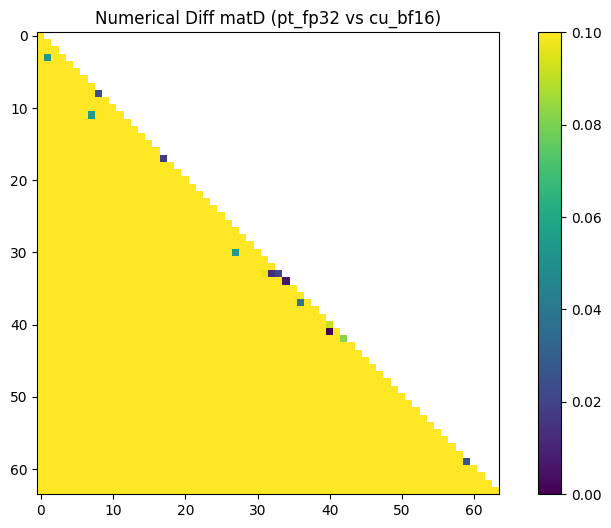

In [591]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_bf16, title="Numerical Diff matD (pt_fp32 vs cu_bf16)", vmax=10e-2)

In [592]:
matD_cu_bf16[:, :, :17, :16]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0

In [593]:
(qs_bf16 @ ks_bf16)[:, :, :17, :16]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262, 0.0262],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0064, 0

In [594]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 64, 64]), torch.Size([1, 1, 64, 64]))

In [595]:
hs_cu_half, qs

(tensor([[[[0.5322, 0.4927, 0.4937, 0.4946, 0.4956, 0.4966, 0.4978, 0.4988, 0.4998, 0.5010, 0.5020, 0.5029, 0.5039, 0.5049, 0.5059, 0.5068, 0.5542, 0.5093, 0.5103, 0.5112, 0.5122, 0.5132, 0.5142,
            0.5151, 0.5161, 0.5171, 0.5181, 0.5190, 0.5205, 0.5215, 0.5225, 0.5234, 0.5244, 0.5254, 0.5264, 0.5273, 0.5283, 0.5293, 0.5308, 0.5317, 0.5327, 0.5337, 0.5347, 0.5356, 0.5366, 0.5376,
            0.5386, 0.5396, 0.5405, 0.5420, 0.5430, 0.5439, 0.5449, 0.5459, 0.5469, 0.5479, 0.5488, 0.5498, 0.5508, 0.5518, 0.5532, 0.5542, 0.5552, 0.5562],
           [2.1797, 2.0156, 2.0195, 2.0254, 2.0293, 2.0332, 2.0371, 2.0410, 2.0449, 2.0488, 2.0547, 2.0586, 2.0625, 2.0664, 2.0703, 2.0742, 2.2676, 2.0840, 2.0879, 2.0918, 2.0957, 2.0996, 2.1035,
            2.1074, 2.1133, 2.1172, 2.1211, 2.1250, 2.1289, 2.1328, 2.1387, 2.1426, 2.1465, 2.1504, 2.1543, 2.1582, 2.1621, 2.1660, 2.1719, 2.1758, 2.1797, 2.1836, 2.1875, 2.1934, 2.1973, 2.2012,
            2.2051, 2.2090, 2.2129, 2.2168, 2.2227, 2.2266,

In [596]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 49.53929138183594
====== Half ======
fw hs match: False, max diff: 8.494769096374512
fw n match: False, max diff: 4.277872085571289
fw m match: False, max diff: 2.679403781890869
fw D match: False, max diff: 49.545692443847656
====== bfloat16 ======
fw hs match: False, max diff: 8.479217529296875
fw n match: False, max diff: 4.277872085571289
fw m match: False, max diff: 2.679403781890869
fw D match: False, max diff: 49.54570007324219


In [597]:
16 / 4

4.0

In [598]:
13 % 4, 14 % 4

(1, 2)

In [599]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

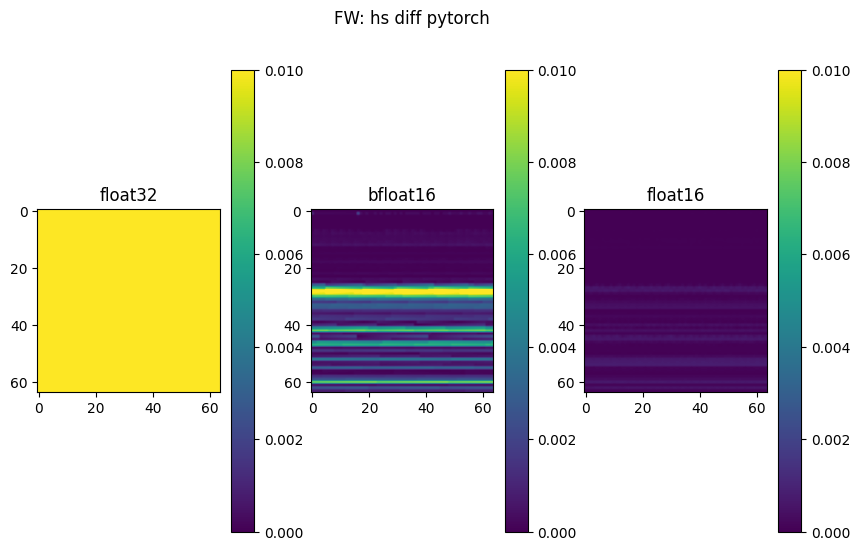

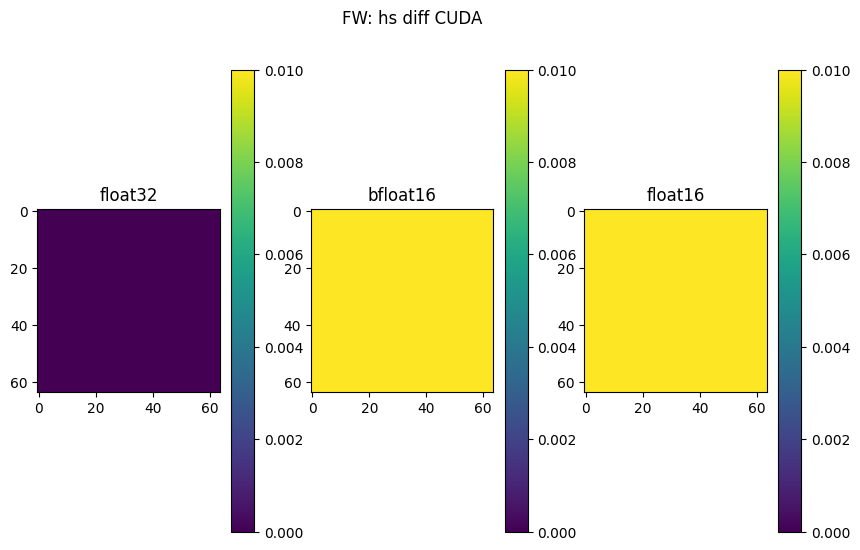

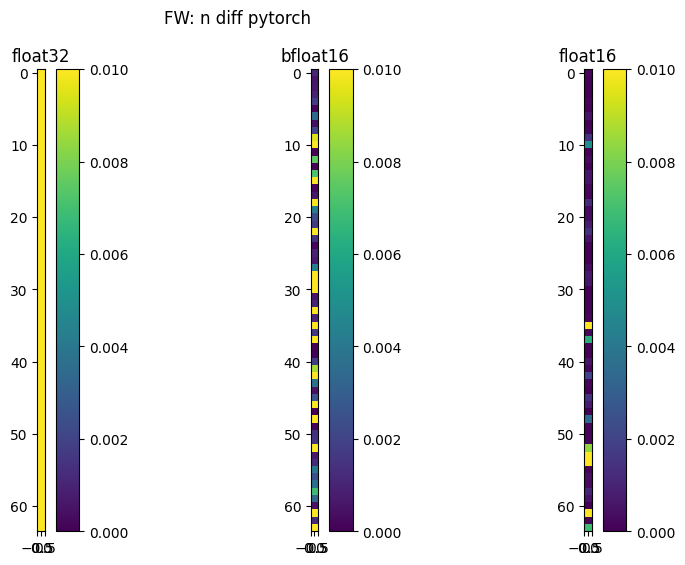

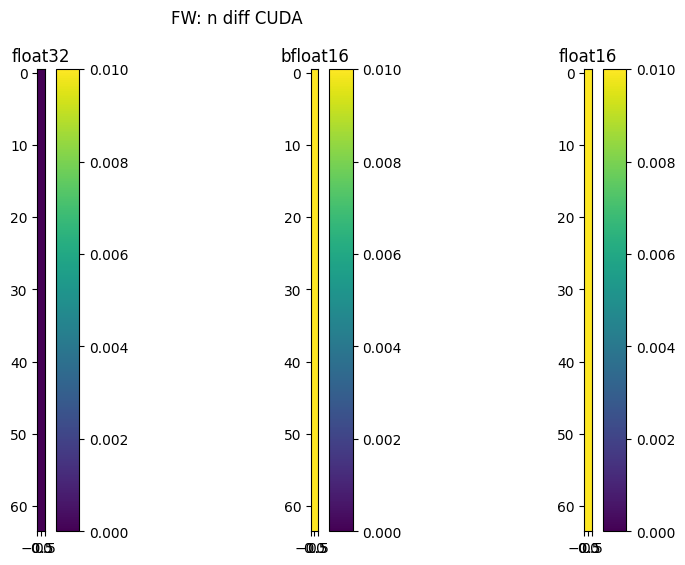

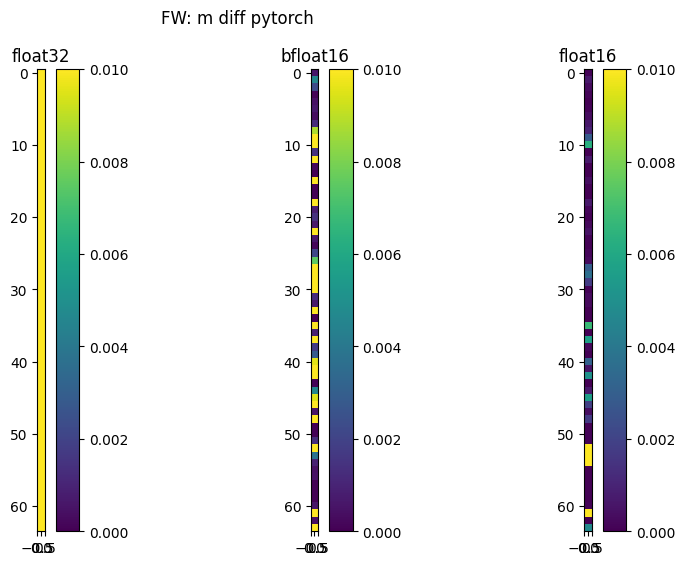

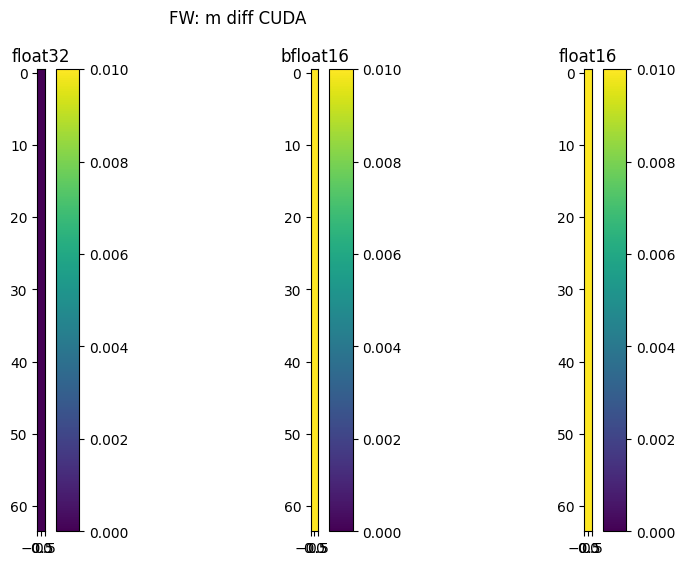

In [600]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")